# Spatial Analysis on School Inequalities in Brunei Darussalam Using

Bayesian Hierarchical Modelling

Alvin Bong

Understanding the spatial distribution of schools is essential for promoting equitable access to education. This study investigates spatial disparities in school availability across Brunei Darussalam, with the aim of identifying potentially underserved areas. An initial exploratory data analysis (EDA) was conducted to examine school counts across mukims. The core analysis applie Bayesian spatial Poisson model using Integrated Nested Laplace Approximation (INLA) to estimate the relative abundance of schools, adjusting for expected counts based on population, geographic area, and a socioeconomic indicator (median house price, partially simulated). Both spatially structured and unstructured random effects were included to account for latent spatial processes. Posterior estimates revealed several mukims with significantly lower school availability relative to the national baseline, offering valuable insights to support future policy planning and equitable school placement.

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Loading required package: sf
Linking to GEOS 3.13.0, GDAL 3.10.3, PROJ 9.6.2; sf_use_s2() is TRUE

Loading required package: terra
terra 1.8.60

Attaching package: 'terra'

The following object is masked from 'package:tidyr':

    extract

Loading required package: viridisLite

Loading required package: spData
To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: Matrix

Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack

This is INLA_25.06.07 built 2025-06-11 18:54:45 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - List available models/likelihoods/etc with inla.list.models()
 - Use inla.doc(<NAME>) to access documentation


Attaching package: 'patchwork'

The following object is masked from 'package:terra':

    area

Rows: 2993 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): state, district, stage, type
dbl  (1): schools
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

character(0)

character(0)

[1] "Matu"     "Pakan"    "Selangau"

character(0)

Rows: 319200 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): state, district, sex, age, ethnicity
dbl  (1): population
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

character(0)

character(0)

character(0)

character(0)

## 1 Introduction

Education is a foundational pillar of national development and its people, influencing social well-being, economic growth, and long-term sustainability. The global significance of education is recognized in Sustainable Development Goal 4, which promotes inclusive and equitable quality education for all ([Assembly 2015](#ref-UNGA2015transform)). Nationally, Brunei Darussalam’s national vision, Wawasan Brunei 2035, positions education as a cornerstone of the country’s long-term development goals ([Brunei Darussalam 2020](#ref-GovernmentBruneiNDwawasan)). Ensuring equitable access to education through sufficient infrastructure and fair resource distribution is critical to delivering quality learning experiences.

While several studies have examined general aspects of education in Brunei, there have been limited studies based on quantitative methods ([Ebil and Shahrill 2023](#ref-ebil2023overview); [Abdul Latif, Matzin, and Escoto-Kemp 2021](#ref-abdul2021development); [Salbrina, Deterding, and Nur Raihan 2024](#ref-salbrina2024education); [Mohamad et al. 2018](#ref-mohamad2018towards)). This project aims to addresses that gap by conducting spatial analysis on schools across the mukims in Brunei, specifically using Bayesian hierarchical models to identify adminstrative regions in Brunei where school availability falls significantly below the national baseline, supporting future policy planning and school placements.

## 2 Data

This study focuses exclusively on government primary and secondary schools in Brunei Darussalam, as these institutions serve as the main access points to education for most youth. Bayesian spatial modeling was conducted using Brunei’s 39 mukims (administrative region) as the unit of analysis to achieve a balance between geographic detail and interpretability. Key data variables that were used include *school counts*, *administrative boundary data*, *population*, and *house prices*. These datasets were mostly sourced from Bruneiverse Github Page, particularly via the `bruneimap` R package, and were subsequently cleaned, wrangled, and merged primarily using `left_join()` and `rbind()` ([Jamil 2025](#ref-bruneimap); [Jamil et al. 2025](#ref-jamil2025archives)).

The school dataset from 2018 was used as it is the most recent year for which disaggregated school-level data is available. Although more recent statistics exist, they are published only in summary form. Population data is drawn from the 2021 national census, the most recent census available in Brunei, despite the mismatch in years with the school dataset. Brunei conducts its national census every ten years, making the 2021 data the best option for population estimates.

To incorporate a socioeconomic indicator, we used median house prices derived from approximately 30,000 property listings spanning 1993–2025. These were calculated at the mukim level and included as a covariate in the Bayesian model. In cases where house price data were missing, values were imputed using predictions from an INLA-based Gaussian model. Manual imputations based on local knowledge were initially tested, but the INLA-predicted values were ultimately adopted, as both methods produced similar model outcomes. Given the nature of the data, house prices were treated as partially simulated estimates and may not fully reflect actual market values.

## 3 Method

Choropath map is used for exploratory data analysis to give an overview of school counts per mukim and overall geography of Brunei.

### 3.1 Spatial regression model

Let $Y_i$ and $E_i$ denote the observed and expected counts of schools, respectively, in mukim $i \in \{1, \dotsc, n\}$. Let $\theta_i$ represent the *relative abundance* of schools in mukim $i$, analogous to a relative risk in disease mapping. The model is specified as follow:

$$
Y_i \mid \theta_i \sim \text{Poisson}(E_i \cdot \theta_i), \quad i = 1, \dotsc, n
$$

$$
\log(\theta_i) = \beta_0 + \beta_1 \cdot \text{pop}_i + \beta_2 \cdot \text{area}_i + \beta_3 \cdot \text{hp}_i + u_i + v_i,
$$

where:

-   $\beta_0$ is the intercept,
-   $\beta_1$, $\beta_2$, and $\beta_3$ are regression coefficients for the standardized covariates:
    -   $\text{pop}_i$: population (in units of 10,000),
    -   $\text{area}_i$: mukim size (in units of 10 km²),
    -   $\text{hp}_i$: median house price (in BND \$1,000,000),
-   $u_i$ is a structured spatial effect, modelled using an intrinsic conditional autoregressive (CAR) prior $u_i \mid u_{-i} \sim \mathcal{N}(\bar{u}_{\delta_i}, \frac{1}{\tau_u n_{\delta_i}})$
-   $v_i$ is an unstructured random effect, $v_i \sim \text{Normal}(0, \frac{1}{\tau_v})$

The spatial random effect $u_i$ requires a neighborhood (adjacency) matrix. Here, We define two mukims as neighbors if they share at least one boundary point (Queen contiguity). The neighborhood graph is constructed using the `poly2nb()` function from the `spdep` package.

Model fitting was performed in a Bayesian framework using the Integrated Nested Laplace Approximation (INLA). Model adequacy with respect to spatial structure is assessed by by examining the spatial autocorrelation ofstandardiszed Pearson residual defined as: $$residual_i = \dfrac{Y_i - \mu_i}{\sqrt{\mu_i}} = \dfrac{Y_i - E_i \cdot \theta_i}{\sqrt{E_i \cdot \theta_i}},$$ where $Y_i$ is the observed count, $E_i$ is the expected count (offset), and $\theta_i$ is the relative risk. Significant residual spatial autocorrelation may indicate unaccounted spatial structure in the model.

### 3.2 Global Moran’s I

To examine whether Pearson residuals of our model exhibit a clustered, dispersed, or random spatial pattern, we apply the Global Moran’s I test using the `global_moran_test()` function from the `spdep` package. This test is computed for each mukim in the study area, indexed by $i, j = 1, 2, \ldots, N$. The Moran’s I test statistic is defined as follows:

$$
I = \frac{N}{\sum_{i=1}^N \sum_{j=1}^N w_{ij}} \frac{\sum_{i=1}^N \sum_{j=1}^N w_{ij} (x_i - \bar{x})(x_j - \bar{x})}{\sum_{i=1}^N (x_i - \bar{x})^2} \in [-1,1],
$$

where:

-   $x_i$ is the Pearson residual in mukim $i$,
-   $\bar{x}$ is the mean residual per mukim,
-   $w_{ij}$ is the spatial weight between mukims $i$ and $j$.

For simplicity, the same Queen Contiguity neighbour is used. Moran’s I values are standardized, with values close to $+1$ indicating positive spatial autocorrelation (i.e., clustering), where high or low values are near each other. Values close to $-1$ indicate negative spatial autocorrelation (i.e., dispersion), where neighboring values differ significantly. Values near $0$ suggest randomness, indicating an absence of spatial pattern. <a href="#fig-autocorrelation" class="quarto-xref">Figure 1</a> shows the three configurations of areas.

<figure id="fig-autocorrelation">
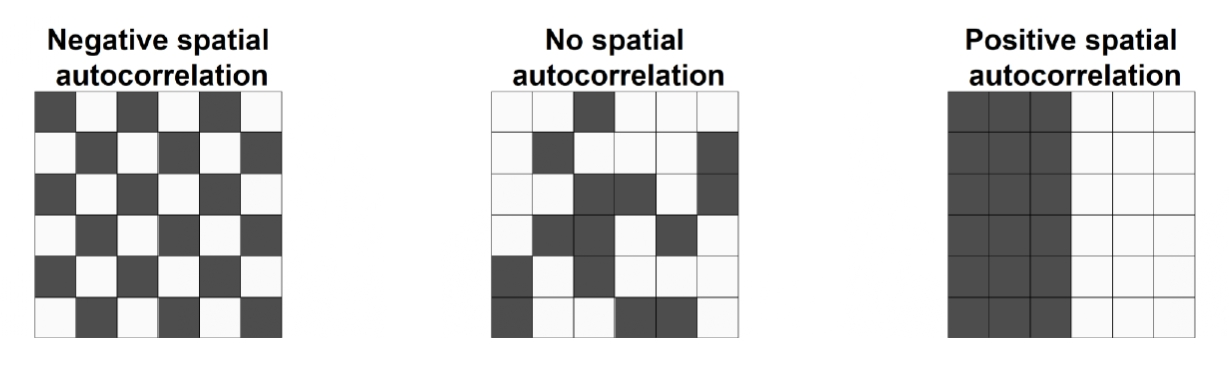
<figcaption>Figure 1: Examples of configurations of areas showing different types of spatial autocorrelation</figcaption>
</figure>

To determine the significance of the Moran’s I statistic, we employ the Central Limit Theorem to calculate p-values based on a Z-score, allowing us to test the following hypotheses:

-   $H_0: I = 0$ (no spatial autocorrelation),
-   $H_1: I \neq 0$ (presence of spatial autocorrelation).

## 4 Results

In [ ]:
nborneo_sch_sf <- nborneo_sch_sf %>% mutate(area = as.numeric(st_area(geometry)))
nborneo_sch_sf <- nborneo_sch_sf %>% mutate(sch_pop = schools/population*100000, # per 10000 people
                                            sch_area = schools/area * 10000000) # per 10 km^2

# m1: sch
label_sf <- nborneo_sch_sf |> 
  arrange(desc(schools)) |> 
  slice_head(n = 5) |> 
  mutate(label = paste0(district, "\n", schools))
m1 <- ggplot() +
  geom_sf(data = nborneo_sch_sf, aes(fill = schools)) +
  geom_sf(data = filter(brn_sf, name=="Mainland"), color="black", alpha=0, linewidth=0.7)+
  ggrepel::geom_label_repel(
    data = label_sf,
    aes(label = label, geometry = geometry),
    stat = "sf_coordinates",
    inherit.aes = FALSE,
    box.padding = 1,
    size = 3,
    alpha = 0.7,
    max.overlaps = Inf
  ) +
  scale_fill_viridis_b(
    option = "E",
    name = "School Count",
    na.value = NA,
    breaks = c(0,20,50,75,100)        # Number of bins
  ) +
  labs(x = NULL, y = NULL) +
  theme_minimal()  +
  theme(legend.position = "top")

# m2: population
label_sf <- nborneo_sch_sf |> 
  arrange(desc(population)) |> 
  slice_head(n = 6) |> 
  mutate(label = paste0(district, "\n", format(population, big.mark=",", scientific=F)))
m2 <- ggplot(nborneo_sch_sf) +
  geom_sf(dat = nborneo_sch_sf, aes(fill = population)) +
  geom_sf(data = filter(brn_sf, name=="Mainland"), color="black", alpha=0, linewidth=0.7)+
  ggrepel::geom_label_repel(
    data = label_sf,
    aes(label = label, geometry = geometry),
    stat = "sf_coordinates",
    inherit.aes = FALSE,
    box.padding = 1,
    size = 3,
    alpha = 0.7,
    force=5,
    max.overlaps = Inf
  ) +
  scale_fill_viridis_b(
    option = "E",
    name = "Population",
    labels = scales::comma,
    na.value = NA,
    breaks = c(0,30000,70000,100000, 200000,400000)        # Number of bins
  ) +
  labs(x = NULL, y = NULL) +
  theme_minimal() +
  theme(legend.position = "top")

#m3: sch_area
label_sf <- nborneo_sch_sf |> 
  arrange(desc(sch_area)) |> 
  slice_head(n = 5) |> 
  mutate(label = paste0(district, "\n", round(sch_area,2)))
m3 <- ggplot() +
  geom_sf(data= nborneo_sch_sf, aes(fill = sch_area)) +
  geom_sf(data = filter(brn_sf, name=="Mainland"), color="black", alpha=0, linewidth=0.7)+
  ggrepel::geom_label_repel(
    data = label_sf,
    aes(label = label, geometry = geometry),
    stat = "sf_coordinates",
    inherit.aes = FALSE,
    box.padding = 1,
    size = 3,
    alpha = 0.7,
    force=5,
    max.overlaps = Inf
  ) +
  scale_fill_viridis_b(
    option = "E",
    name = "School per 10 km^2",
    na.value = NA,
    breaks = c(0,0.1,0.2,0.3,0.5,1)        # Number of bins
  ) +
  labs(x = NULL, y = NULL) +
  theme_minimal() +
  theme(legend.position = "top")

# m4: sch_pop
label_sf <- nborneo_sch_sf |> 
  arrange(sch_pop) |> 
  slice_head(n = 5) |> 
  mutate(label = paste0(district, "\n", round(sch_pop,1)))
m4 <- ggplot() +
  geom_sf(data = nborneo_sch_sf, aes(fill = sch_pop)) +
  geom_sf(data = filter(brn_sf, name=="Mainland"), color="black", alpha=0, linewidth=0.7) +
  ggrepel::geom_label_repel(
    data = label_sf,
    aes(label = label, geometry = geometry),
    stat = "sf_coordinates",
    inherit.aes = FALSE,
    box.padding = 1,
    size = 3,
    alpha = 0.7,
    force=5,
    max.overlaps = Inf
  ) +
  scale_fill_viridis_b(
    option = "E",
    name = "School per 10000 people",
    na.value = NA,
    breaks = c(0,50,100,200)        # Number of bins
  ) +
  labs(x = NULL, y = NULL) +
  theme_minimal() +
  theme(legend.position = "top")

In [ ]:
brn_tchr <- bruneimap::tchr %>% 
  mutate(teachers = as.numeric(M) + as.numeric(`F`),
         district = District,
         stage = case_when(
           `Education Level` == "Primary" ~ "primary",
           `Education Level` == "Secondary" ~ "secondary",
           TRUE ~ `Education Level`)) %>% 
  filter(Sector == "MOE",
         stage %in% c("primary", "secondary")) %>% 
  select(district, stage, teachers)

brn_enrolment <- bruneimap::enrolment %>% 
  mutate(students = as.numeric(M) + as.numeric(`F`),
         district = District,
         stage = case_when(
           `Education Level` == "Primary" ~ "primary",
           `Education Level` == "Secondary" ~ "secondary",
           TRUE ~ `Education Level`)) %>% 
  filter(Sector == "MOE",
         stage %in% c("primary", "secondary")) %>% 
  select(district, stage, students)

mys_tchr <- read_csv("source/mys_teacher.csv")

Rows: 5917 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): state, district, stage, sex
dbl  (1): teachers
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 8465 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): state, district, stage, sex
dbl  (1): students
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

`summarise()` has grouped output by 'district'. You can override using the
`.groups` argument.

`summarise()` has grouped output by 'district'. You can override using the
`.groups` argument.

character(0)

[1] "Matu"     "Pakan"    "Selangau"

character(0)

[1] "Matu"     "Pakan"    "Selangau"

### 4.1 Exploratory Data Analysis

<a href="#fig-sch" class="quarto-xref">Figure 2</a> shows that mukims with higher schools count located in the coastal region near South China Sea. As expected, majority of mukims with high school count are in Brunei-Muara District (north-east of mainland), the most populated and urban district in Brunei.

In [ ]:
label_sf <- brn_mkm_sch_sf |> 
  arrange(desc(schools)) |> 
  slice_head(n = 5) |> 
  mutate(label = paste0(mukim, "\n", schools))
ggplot() +
  geom_sf(data = brn_mkm_sch_sf, aes(fill = schools)) +
  geom_sf(data = mkm_sf, color="grey", alpha=0, linewidth=0.7) +
  geom_sf(data = dis_sf, color="red", alpha=0, linewidth=0.5) +
  ggrepel::geom_label_repel(
    data = label_sf,
    aes(label = label, geometry = geometry),
    stat = "sf_coordinates",
    inherit.aes = FALSE,
    box.padding = 1,
    size = 2.5,
    alpha = 0.7,
    force=5,
    max.overlaps = Inf
  ) +
  scale_fill_viridis_b(
    option = "E",
    direction = 1,
    name = "School \nCount",
    na.value = NA,
    breaks = c(0,2,4,6,8)    # Number of bins
  ) +
  labs(x = NULL, y = NULL) +
  theme_minimal()

Warning in st_point_on_surface.sfc(sf::st_zm(x)): st_point_on_surface may not
give correct results for longitude/latitude data

### 4.2 Model

In [ ]:
# Model y ~ pop + hp (socioeconomic) + u_i +v_i (Only Brunei, by mukim) --------------------------

# hp
hp <- read_csv("source/brn_house_price.csv")

Rows: 31116 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): quarter, kampong, mukim, district, type, tenure, status, agent, s...
dbl   (7): id, price, plot_area, floor_area, storeys, beds, baths
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

 [1] "Mukim Melilas"            "Mukim Sukang"            
 [3] "Mukim Kuala Balai"        "Mukim Bukit Sawat"       
 [5] "Mukim Bokok"              "Mukim Labu"              
 [7] "Mukim Burong Pingai Ayer" "Mukim Saba"              
 [9] "Mukim Peramu"             "Mukim Tamoi"             
[11] "Mukim Ukong"              "Mukim Sungai Kedayan"    

Warning in poly2nb(brn_mkm_sch_sf): neighbour object has 2 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.

 [1] 12.31093 12.31431 12.55397 12.79899 12.34949 13.09716 12.14464 12.57048
 [9] 12.34605 12.32399 12.46060 12.53155 12.25047 12.57254 12.29276 12.84757
[17] 12.62717 12.65946 12.65074 12.61542 12.54256 11.83580 12.61149 12.54250
[25] 12.76548 12.61146 12.57078 12.54259 11.98371 12.37442 12.42108 12.33722
[33] 12.42918 12.34598 13.09102 12.63962 12.66031 12.56034 12.87345

Mean            241118 
Stdev           99485.9 
Quantile  0.025 93485.8 
Quantile  0.25  171683 
Quantile  0.5   225664 
Quantile  0.75  291831 
Quantile  0.975 481007 
Mean            234276 
Stdev           75789.2 
Quantile  0.025 118844 
Quantile  0.25  180360 
Quantile  0.5   222996 
Quantile  0.75  275327 
Quantile  0.975 414721 
Mean            296428 
Stdev           91673.5 
Quantile  0.025 155485 
Quantile  0.25  231637 
Quantile  0.5   283114 
Quantile  0.75  345943 
Quantile  0.975 514343 
Mean            361870 
Stdev           3695.85 
Quantile  0.025 353708 
Quantile  0.25  360100 
Quantile  0.5   361881 
Quantile  0.75  363645 
Quantile  0.975 369862 
Mean            240816 
Stdev           72055.7 
Quantile  0.025 130913 
Quantile  0.25  189829 
Quantile  0.5   230005 
Quantile  0.75  279521 
Quantile  0.975 412847 
Mean            487581 
Stdev           4994.73 
Quantile  0.025 476061 
Quantile  0.25  485279 
Quantile  0.5   487729 
Quantile  0.75  490070 
Quantile 

Warning in st_point_on_surface.sfc(sf::st_zm(x)): st_point_on_surface may not
give correct results for longitude/latitude data

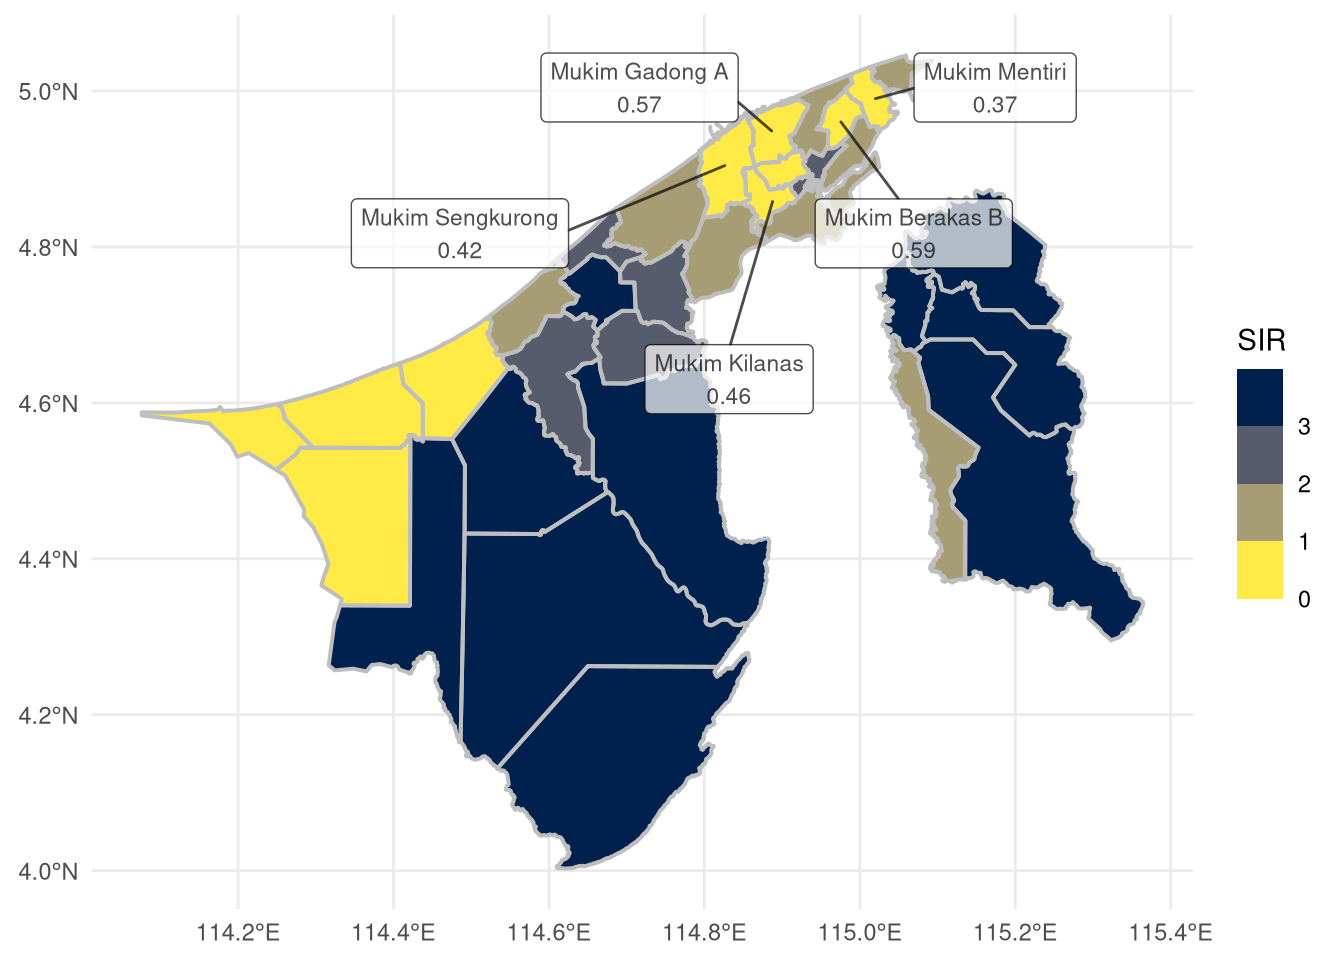

In [ ]:
# SIR
label_sf <- brn_mkm_sch_sf |> 
  filter(SIR!=0) |> 
  arrange(SIR) |> 
  slice_head(n = 5) |> 
  mutate(label = paste0(mukim, "\n", round(SIR,2)))
ggplot() +
  geom_sf(data = brn_mkm_sch_sf, aes(fill = SIR)) +
  geom_sf(data = filter(mkm_sf), color="grey", alpha=0, linewidth=0.7) +
  ggrepel::geom_label_repel(
    data = label_sf,
    aes(label = label, geometry = geometry),
    stat = "sf_coordinates",
    inherit.aes = FALSE,
    box.padding = 1,
    size = 3,
    alpha = 0.7,
    force=5,
    max.overlaps = Inf
  ) +
  scale_fill_viridis_b(
    option = "E",
    direction = -1,
    name = "SIR",
    na.value = NA,
    breaks = c(0,1,2,3)    # Number of bins
  ) +
  labs(x = NULL, y = NULL) +
  theme_minimal()

In [ ]:
nb <- poly2nb(brn_mkm_sch_sf)

Warning in poly2nb(brn_mkm_sch_sf): neighbour object has 2 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.

Time used:
    Pre = 2.88, Running = 0.953, Post = 0.0403, Total = 3.87 
Fixed effects:
              mean     sd 0.025quant 0.5quant 0.975quant   mode kld
(Intercept)  1.046  0.397      0.257    1.049      1.818  1.049   0
pop_s       -0.437  0.072     -0.579   -0.437     -0.296 -0.437   0
area_s       0.016  0.009     -0.001    0.016      0.034  0.016   0
hp_s        -6.528 11.516    -28.945   -6.594     16.281 -6.588   0

Random effects:
  Name    Model
    re_u BYM2 model

Model hyperparameters:
                      mean       sd 0.025quant 0.5quant 0.975quant   mode
Precision for re_u 1153.75 8110.198      9.353  149.975    7798.87 19.639
Phi for re_u          0.36    0.279      0.013    0.293       0.93  0.021

Marginal log-Likelihood:  -65.86 
 is computed 
Posterior summaries for the linear predictor and the fitted values are computed
(Posterior marginals needs also 'control.compute=list(return.marginals.predictor=TRUE)')

                   mean           sd    0.025quant   0.5quant  0.975quant
(Intercept)  1.04602217  0.397489773  2.566904e-01  1.0488814  1.81825795
pop_s       -0.43707817  0.072303684 -5.794819e-01 -0.4369151 -0.29564097
area_s       0.01610521  0.008811992 -9.804561e-04  0.0160325  0.03362208
hp_s        -6.52830530 11.515874758 -2.894521e+01 -6.5941854 16.28072052
                   mode          kld
(Intercept)  1.04859091 1.810627e-08
pop_s       -0.43692906 4.870341e-09
area_s       0.01603795 2.111383e-08
hp_s        -6.58828611 1.325594e-08

The model results show that the intercept is estimated at $\hat{\beta}_0 = 1.077$, with a 95% credible interval of $(0.239, 1.894)$. The coefficient for population, $\beta_1 = -0.436$, with a 95% credible interval of $(-0.579, -0.295)$, indicates a statistically significant negative relationship between population size and relative school abundance. Specifically, for every 10,000 increase in population, the relative abundance of schools decreases by approximately 35%, since $\exp(-0.436) \approx 0.647$. In contrast, the covariates: mukim size and house price are not statistically significant. The coefficient for mukim size is $\hat{\beta_2}=0.015$ (95% CI: -0.002, 0.032), and for house price is $\hat{\beta_3}=-0.759$ (95% CI: -3.174, 1.704).

The estimated relative abundance (RA) of schools across mukims (<a href="#fig-ra" class="quarto-xref">Figure 3</a>)vindicates lower values in the northern coastal mukims, particularly in northern Brunei-Muara District, along the South China Sea. Conversely, higher RA values appear inland, especially in less densely populated regions.

To identify mukims with potentially inadequate school provision, non-exceedence probabilities were computed for a threshold of $RA <0.7$. The analysis (<a href="#fig-exc" class="quarto-xref">Figure 4</a>) indicates that it is highly likely that several mukims fall below this threshold, including **Mukim Sengkurong, Mukim Gadong A, Mukim Gadong B, Mukim Berakas B, and Mukim Mentiri**.

Lastly, the global Moran’s I statistic of $0.213$ ($p<0.05$) provides statistically significant evidence to reject the null hypothesis of no spatial autocorrelation in the residuals.

In [ ]:
label_sf <- brn_mkm_sch_sf |> 
  filter(RA!=0) |> 
  arrange(RA) |> 
  slice_head(n = 5) |> 
  mutate(label = paste0(mukim, "\n", round(RA,2)))
ggplot() +
  geom_sf(data = brn_mkm_sch_sf, aes(fill = RA)) +
  geom_sf(data = mkm_sf, color="grey", alpha=0, linewidth=0.7) +
  ggrepel::geom_label_repel(
    data = label_sf,
    aes(label = label, geometry = geometry),
    stat = "sf_coordinates",
    inherit.aes = FALSE,
    box.padding = 1,
    size = 3,
    alpha = 0.7,
    force=5,
    max.overlaps = Inf
  ) +
  scale_fill_viridis_b(
    option = "E",
    direction = -1,
    name = "RA",
    na.value = NA,
    breaks = c(0,1,2,3)    # Number of bins
  ) +
  labs(x = NULL, y = NULL) +
  theme_minimal()

Warning in st_point_on_surface.sfc(sf::st_zm(x)): st_point_on_surface may not
give correct results for longitude/latitude data

In [ ]:
brn_mkm_sch_sf$exc <- sapply(res$marginals.fitted.values,
                    FUN = function(marg){inla.pmarginal(q = 0.7, marginal = marg)})

label_sf <- brn_mkm_sch_sf |> 
  arrange(desc(exc)) |> 
  slice_head(n = 6) |> 
  mutate(label = paste0(mukim, "\n", round(exc,2)))
ggplot() +
  geom_sf(data = brn_mkm_sch_sf, aes(fill = exc)) +
  geom_sf(data = mkm_sf, color="grey", alpha=0, linewidth=0.7) +
  ggrepel::geom_label_repel(
    data = label_sf,
    aes(label = label, geometry = geometry),
    stat = "sf_coordinates",
    inherit.aes = FALSE,
    box.padding = 1,
    size = 3,
    alpha = 0.7,
    force=5,
    max.overlaps = Inf
  ) +
  scale_fill_viridis_b(
    option = "E",
    direction = 1,
    name = "Non-exceedance \nProbability \nRA<0.7",
    na.value = NA,
    breaks = c(0,0.25,0.5,0.75)    # Number of bins
  ) +
  labs(x = NULL, y = NULL) +
  theme_minimal()

Warning in st_point_on_surface.sfc(sf::st_zm(x)): st_point_on_surface may not
give correct results for longitude/latitude data

In [ ]:
fitted_counts <- brn_mkm_sch_sf$E * brn_mkm_sch_sf$RA
brn_mkm_sch_sf$residuals_pearson <- (brn_mkm_sch_sf$Y - fitted_counts) / sqrt(fitted_counts)
ggplot() +
  geom_sf(data = brn_mkm_sch_sf, aes(fill = residuals_pearson)) +
  geom_sf(data = mkm_sf, color="grey", alpha=0, linewidth=0.7) +
  scale_fill_viridis_b(
    option = "E",
    direction = 1,
    name = "Residual",
    na.value = NA,
    n.breaks = 6    # Number of bins
  ) +
  labs(x = NULL, y = NULL) +
  theme_minimal()

## 5 Discussion

The results in <a href="#sec-results" class="quarto-xref">Section 4</a> offer insights into both overall model performance and patterns of educational equity. Global Moran’s I statistic (0.213) is not substantially high (\<0.3), suggesting that the model captures most, but not all, of the residual spatial dependence. This is illustrated in <a href="#fig-res" class="quarto-xref">Figure 5</a>, where the variation in residual colors suggests a reasonably good fit, though further improvement may be possible with additional spatial covariates or refined random effects. The negative relationship between population and school counts, as well as higher RA values in inland (rural) mukims than coastal ares with larger population suggests that school availability in rural mukims seem to be adequate, potentially due to legacy planning policies or intentional efforts to ensure equitable access in remote areas.

In contrast, urban and peri-urban mukims in the Brunei-Muara District, the country’s most densely populated and economically active region, show signs of disparities in school access. Notably, the high non-exceedance probability of $RA < 0.7$ in **Mukim Sengkurong, Gadong A & B, Berakas B, and Mentiri** indicates that they have fewer schools than expected relative to their population sizes. These disparities highlight areas that may be underinvested in educational infrastructure, warranting closer policy attention.

Importantly, these mukims are also encompass several new government housing developments, such as Perpindahan Lugu and Perpindahan Tanah Jambu. This suggests a potential planning gap, where population is increasing due to housing developments, but educational infrastructure has not yet caught up.

However, inspection of <a href="#fig-sch" class="quarto-xref">Figure 2</a> reveals that these areas have a similar number of schools compared to their neighboring mukims. This suggests that while the absolute number of schools may not be unusually low, the rapid increase in population within these new housing areas may have outpaced school capacity, leading to a situation where demand exceeds supply within these specific zones.

Nevertheless, this situation represents a strategic opportunity. Prioritizing school construction in these fast-growing neighborhoods could significantly improve access to education, reduce commute times, lower transportation costs, and enhance the overall quality of life for residents. Locating schools closer to homes supports national goals related to sustainable urban development, walkability, and equity in public services.

### 5.1 Limitations

This study is limited to public schools, excluding private and international institutions that may affect school availability in some areas. The data is from 2018, potentially missing recent changes, especially in fast-growing neighborhoods. Next, our model used the general population data and is not age-standardized, are important for demand estimation. Housing price was used as a proxy for socioeconomic status, but data relies on listing prices, which may not reflect actual market values due to negotiation factors. In some areas, price data was also simulated, introducing further uncertainty. <!-- have not taken into account school size/ assume schools are all same size -->

## 6 Conclusions

In summary, our model reveals a negative relationship between population size and relative school abundance, suggesting urban areas have fewer schools per capita than rural ones. Several mukims in the Brunei-Muara District, including Sengkurong, Gadong A & B, Berakas B, and Mentiri, appear to have fewer schools than expected, despite ongoing population growth driven by new housing developments. While total school counts may seem adequate, local demand in these areas may exceed capacity. Addressing this gap offers a strategic opportunity to improve access, reduce travel time, and support equitable urban planning.

## References

Abdul Latif, Siti Norhedayah, Rohani Matzin, and Aurelia Escoto-Kemp. 2021. “The Development and Growth of Inclusive Education in Brunei Darussalam.” *Globalisation, Education, and Reform in Brunei Darussalam*, 151–75. <https://doi.org/10.1007/978-3-030-77119-5_8>.

Assembly, United Nations General. 2015. “Transforming Our World: The 2030 Agenda for Sustainable Development.” <https://sustainabledevelopment.un.org/post2015/transformingourworld>.

Brunei Darussalam, Government of. 2020. “Brunei Darussalam Long-Term Development Plan. Wawasan Brunei 2035.”

Ebil, Syazana, and Masitah Shahrill. 2023. “Overview of Education in Brunei Darussalam.” In *International Handbook on Education in South East Asia*, 1–21. Springer. <https://doi.org/10.1007/978-981-16-8136-3_46-1>.

Jamil, Haziq. 2025. *Bruneimap: Maps and Spatial Data of Brunei (R Package Version 0.3.1.9001)*. <https://bruneiverse.github.io/bruneimap/>.

Jamil, Haziq, Amira Barizah Noorosmawie, Hafeezul Waezz Rabu, and Lutfi Abdul Razak. 2025. “From Archives to AI: Residential Property Data Across Three Decades in Brunei Darussalam.” *Data in Brief*, March. <https://doi.org/10.1016/j.dib.2025.111505>.

Mohamad, Hanapi, Rosyati M Yaakub, Emma Claire Pearson, and Jennifer Tan Poh Sim. 2018. “Towards Wawasan Brunei 2035: Early Childhood Education and Development in Brunei Darussalam.” *International Handbook of Early Childhood Education*, 551–67. <https://doi.org/10.1007/978-94-024-0927-7_25>.

Salbrina, Sharbawi, David Deterding, and Mohamad Nur Raihan. 2024. “Education in Brunei.” In *Brunei English: A New Variety in a Multilingual Society*, 17–32. Springer. <https://doi.org/10.1007/978-3-031-60303-7_2>.